In [1]:
import pandas as pd
from typing import Union, List, Optional
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt


def add_fdr_column(
    df: pd.DataFrame,
    p_col: str = "p_value",
    out_col: str = "p_value_adj",
    method: str = "fdr_bh",
    alpha: float = 0.05,
    inplace: bool = False,
) -> pd.DataFrame:
    """
    Add an FDR-adjusted p-value column to a DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame containing raw p-values.
    p_col : str, default "p_value"
        Name of the column with raw p-values.
    out_col : str, default "p_value_adj"
        Name of the column to store adjusted p-values.
    method : str, default "fdr_bh"
        Correction method accepted by statsmodels.stats.multitest.multipletests
        (e.g., "fdr_bh", "fdr_by", "bonferroni", "holm").
    alpha : float, default 0.05
        Significance level used by multipletests when computing reject decisions
        (returned but not used further here).
    inplace : bool, default False
        If True, modify the original DataFrame; otherwise operate on a copy.

    Returns
    -------
    pd.DataFrame
        DataFrame with a new column containing FDR-adjusted p-values.
    """
    work_df: Union[pd.DataFrame, pd.core.generic.NDFrame]
    work_df = df if inplace else df.copy()

    # multipletests returns: reject, pvals_corrected, _, _
    _, qvals, _, _ = multipletests(
        work_df[p_col].astype(float).to_numpy(), alpha=alpha, method=method
    )
    work_df[out_col] = qvals
    return work_df

def plot_ratio_bars(
    df: pd.DataFrame,
    rows: List[int],
    ax: Optional[plt.Axes] = None,
    bar_kwargs: Optional[dict] = None,
    err_kwargs: Optional[dict] = None,
    label_rotation: int = 45,
    save_pdf: Optional[str] = None  # NEW: optionally save figure to this path
) -> plt.Axes:
    """
    Plot 'ratio_real' with error bars ('ratio_std') for the specified rows.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain 'ratio_real', 'ratio_std', 'cell_type1', 'cell_type2'.
    rows : list[int]
        Row indices to include in the plot.
    ax : matplotlib.axes.Axes, optional
        Axis to plot on. If None, a new figure/axis is created.
    bar_kwargs : dict, optional
        Extra kwargs forwarded to `ax.bar`.
    err_kwargs : dict, optional
        Keyword arguments forwarded to `ax.bar` via `error_kw`.
    label_rotation : int, default 45
        Rotation angle for x-axis tick labels.
    save_pdf : str or None, default None
        File path to save the figure as PDF. If None, figure is not saved.

    Returns
    -------
    matplotlib.axes.Axes
        Axis containing the bar plot.
    """
    if bar_kwargs is None:
        bar_kwargs = {}
    if err_kwargs is None:
        err_kwargs = dict(ecolor="black", capsize=3, lw=1)

    if ax is None:
        fig, ax = plt.subplots(figsize=(1.2 * len(rows) + 2, 6))
    else:
        fig = ax.figure

    sel = df.loc[rows]
    heights = sel["ratio_real"].to_numpy()
    errors = sel["ratio_std"].to_numpy()
    labels = (sel["cell_type1"] + "-" + sel["cell_type2"]).to_list()

    x = range(len(rows))
    ax.bar(
        x,
        heights,
        yerr=errors,
        error_kw=err_kwargs,
        **bar_kwargs,
    )
    ax.set_xticks(list(x))
    ax.set_xticklabels(labels, rotation=label_rotation, ha="right")
    ax.set_ylabel("ratio_real")
    ax.set_xlabel("CellType1-CellType2")
    ax.set_title("Ratio Real with Standard Deviation")
    ax.axhline(1, color="red", linestyle="--", linewidth=1)  # horizontal reference line
    ax.margins(y=0.1)

    if save_pdf is not None:                                  
        fig.savefig(save_pdf, format="pdf", bbox_inches="tight")

    return ax

In [2]:
CB = pd.read_csv('Cerebellum_proximity_scores.csv',index_col=0)
HP = pd.read_csv('Hippocampus_proximity_scores.csv',index_col=0)

In [3]:
add_fdr_column(CB, inplace=True, method="fdr_by")
add_fdr_column(HP, inplace=True, method="fdr_by")

,cell_type1,cell_type2,pval-adjusted_3,pval_3,z_score_3,contact_count_3,permutation_mean_3,permutation_std_3,region,age_3,...,permutation_std_24,age_24,z_statistic,p_value,p_value_adj,Region,ratio_real,ratio_mean,ratio_std,z_score
1401,DG Glut,DG Glut,1.550609e-69,2.683644e-73,18.071261,1796,905.612,49.270939,Hippocampus,3,...,101.457025,24,31.811869,1.161835e-03,1.830050e-01,Hippocampus,2.997773,3.754489,0.232973,-3.248088
1403,Ependymal NN,Ependymal NN,3.760917e-24,1.952709e-27,10.788397,326,123.048,18.812063,Hippocampus,3,...,5.405092,24,-13.998759,3.631585e-01,1.000000e+00,Hippocampus,0.159509,0.116410,0.047395,0.909363
1404,DG Glut,L2/3 IT CTX Glut,1.504694e-21,1.041671e-24,10.195191,426,249.209,17.340626,Hippocampus,3,...,39.649469,24,24.216879,2.316585e-03,3.087565e-01,Hippocampus,3.460094,4.537043,0.353524,-3.046323
1405,CA1-ProS Glut,DG Glut,1.347434e-16,1.166004e-19,8.996419,225,118.137,11.878393,Hippocampus,3,...,18.461152,24,5.694124,1.190102e-02,1.000000e+00,Hippocampus,1.555556,2.246324,0.274652,-2.515066
1406,CA1-ProS Glut,L2/3 IT CTX Glut,4.241876e-14,4.404856e-17,8.319820,190,103.719,10.370537,Hippocampus,3,...,21.914567,24,22.396823,4.168848e-01,1.000000e+00,Hippocampus,3.857895,4.242636,0.473914,-0.811838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2071,CA1-ProS Glut,OPC NN,9.642906e-01,9.626217e-01,-1.781954,17,27.734,6.023723,Hippocampus,3,...,8.127501,24,5.140169,5.560477e-04,9.634366e-02,Hippocampus,4.058824,2.153422,0.551939,3.452194
2075,Astro-TE NN,MSN D1 Gaba,9.947300e-01,9.936971e-01,-2.494713,6,16.495,4.206896,Hippocampus,3,...,7.190209,24,6.242129,4.377831e-12,7.585254e-09,Hippocampus,9.666667,3.223401,0.930514,6.924414
2076,Astro-TE NN,CA1-ProS Glut,9.969232e-01,9.960605e-01,-2.657209,67,96.042,10.929512,Hippocampus,3,...,17.959586,24,6.849374,4.069018e-01,1.000000e+00,Hippocampus,3.149254,2.839612,0.373351,0.829358
2079,Ependymal NN,MH Tac2 Glut,9.995732e-01,9.992272e-01,-3.165968,71,121.785,16.040909,Hippocampus,3,...,6.712672,24,-3.450495,3.484946e-01,1.000000e+00,Hippocampus,0.154930,0.212908,0.061843,-0.937513


<Axes: title={'center': 'Ratio Real with Standard Deviation'}, xlabel='CellType1-CellType2', ylabel='ratio_real'>

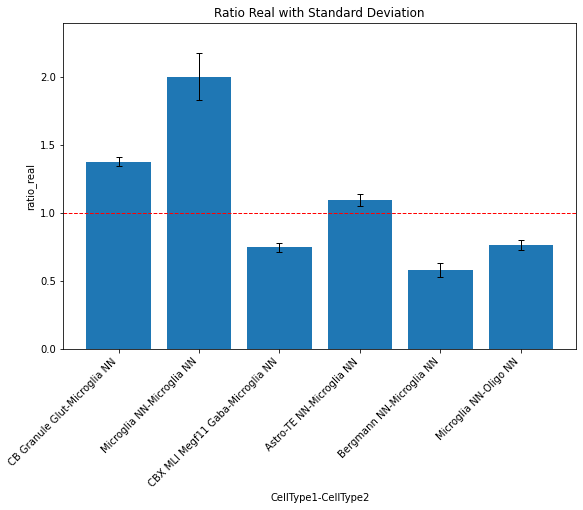

In [4]:
plot_ratio_bars(
    CB[((CB.cell_type1 == 'Microglia NN') | (CB.cell_type2 == 'Microglia NN'))],
    [1392,71, 20, 27, 75, 82],
    save_pdf='figures/CB_proximity_plot.pdf'
)

<Axes: title={'center': 'Ratio Real with Standard Deviation'}, xlabel='CellType1-CellType2', ylabel='ratio_real'>

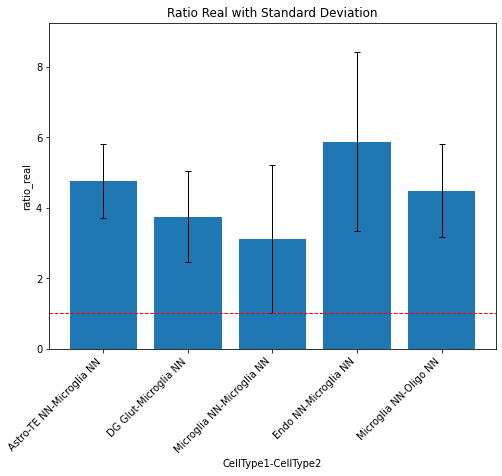

In [5]:
plot_ratio_bars(
    HP[((HP.cell_type1 == 'Microglia NN') | (HP.cell_type2 == 'Microglia NN'))],
    [1456,1541, 1444, 1662, 1483],
    save_pdf='figures/HP_proximity_plot.pdf'
)